In [1]:
#!pip install impyute
#!pip install fsspec
#!pip install klib
import klib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import warnings
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from statsmodels.tools.eval_measures import rmse
#from impyute.imputation.cs import mice

warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [2]:
original_train_data =  pd.read_csv('C://Users/sbhardwaj/Documents/shubham/Big Data and Data Science/MachineHack/DataEng_TeaPrice/train.csv')
original_test_data = pd.read_csv('C://Users/sbhardwaj/Documents/shubham/Big Data and Data Science/MachineHack/DataEng_TeaPrice/test.csv')
print("shape of train data : ",original_train_data.shape[0])
original_train_data = original_train_data.dropna(subset=['Average'], axis = 0, how ='any')
print("shape of train data after dropping rows where Class col is null : ",original_train_data.shape[0])
print("shape of test data : ",original_test_data.shape[0])
original_test_data = original_test_data.dropna(subset=['WeekEnding_Date'], axis = 0, how ='any')
print("shape of test data after dropping rows where Artist_Name col is null : ",original_test_data.shape[0])

shape of train data :  544
shape of train data after dropping rows where Class col is null :  544
shape of test data :  29
shape of test data after dropping rows where Artist_Name col is null :  29


In [3]:
train_data = original_train_data.copy()
test_data = original_test_data.copy()

In [4]:
def get_missing_value_df(train_df):  
    percent_missing = train_df.isnull().mean().round(4)*100
    
    missing_value_df = pd.DataFrame({'dtype' : train_df.dtypes, 
                                     'percent_missing': percent_missing}).rename_axis('column_name').reset_index()
    missing_value_df = missing_value_df[missing_value_df.percent_missing>0].sort_values(by = ['percent_missing'], ascending=False)
    return missing_value_df

def check_missing_values(data_frame):
    missing_value_df = get_missing_value_df(data_frame)
    print("Percentage of Missing values in categorical colmuns\n", missing_value_df.loc[(missing_value_df.percent_missing>0) 
                & (missing_value_df.dtype=="object")].sort_values(by = ['percent_missing'], ascending=False), end="\n\n")
    print("Percentage of Missing values in non categorical colmuns\n", missing_value_df.loc[(missing_value_df.percent_missing>0) 
                & (missing_value_df.dtype!="object")].sort_values(by = ['percent_missing'], ascending=False), end="\n\n" )

#Resolving data type issue
def covertDataType(df):
    df['WeekEnding_Date'] = pd.to_datetime(df.WeekEnding_Date)
    cols = df.columns[df.dtypes.eq('object')]
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    return df

# Data Imputation
def data_imputer(df):
    knn_imputer = KNNImputer(n_neighbors=3)
    return pd.DataFrame(knn_imputer.fit_transform(df), columns = df.columns)
    #return pd.DataFrame(mice(df.values), columns = df.columns)

#Plotting box plots
def box_plots(df):
    for column in df:
        plt.figure()
        df.boxplot([column])

def outliers(df, ft):
    upper_boundary =df[ft].mean() + 3*df[ft].std()
    lower_boundary =df[ft].mean() - 3*df[ft].std()
    ls = df.index[(df[ft]<lower_boundary) | (df[ft]>upper_boundary)]
    return ls

def outlier_index(df):
    index_lst=[]
    for i in df.columns:
        index_lst.extend(outliers(df, i))
    return index_lst

def remove_outlier(df, index_lst):
    return df.drop(index_lst)

def calculate_IQR(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    #print(IQR)
    return Q1, Q3, IQR

def outlier_IQR(df):
    Q1, Q3, IQR = calculate_IQR(df)
    return (df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))
    
def remove_outlier_IQR(df):
    Q1, Q3, IQR = calculate_IQR(df)
    df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
    print('Shape of dataset after removing outliers :', df.shape)
    return df

def remove_all_outliers_EQR_rec(df):
    while(True):
        temp_df = outlier_IQR(df)
        print('\nOutliers in each col:\n',temp_df.sum())
        print('Total Outliers: ',temp_df.sum().sum())
        if temp_df.sum().sum() > 0:
            df = remove_outlier_IQR(df)
        else:
            break
    return df

In [5]:
train_data.head()

,WeekEnding_Date,Kolkata_Average_Price,Kolkata_Ref_Price,Bangalore_Average_Price,Bangalore_Ref_Price,Cochin_Average_Price,Cochin_Ref_Price,Darjeeling_Average_Price,Darjeeling_Ref_Price,Ernakulam_Average_Price,Ernakulam_Ref_Price,Siliguri_Average_Price,Siliguri_Ref_Price,Guwahati_Average_Price,Guwahati_Ref_Price,Average
0,03/01/09,99.01,79.79,N.S.,76.19,84.02,70.07,81.66,57.83,68.94,51.67,70.74,53.88,65.55,46.75,69.700000
1,10/01/09,97.74,78.73,87.48,73.97,82.72,68.17,83.31,58.02,67.24,52.23,70.47,53.39,67.39,46.84,70.550000
2,17/01/09,95.95,71.01,87.66,71.01,80.58,67.16,82.25,57.49,69.64,52.48,71.66,53.18,69.51,48.04,69.830000
3,24/01/09,94.14,73.38,85.69,65.66,N.S.,65.57,80.87,54.59,N.S.,53.43,71.12,52.07,69.14,48.5,67.846667
4,31/01/09,91.45,70.39,N.S.,64.99,79.27,62.09,80.76,57.06,69.65,53.38,72.3,52.5,69.39,50.33,67.196923


In [6]:
train_data.describe()

,Average
count,544.000000
mean,100.660317
std,13.711767
min,64.171250
25%,89.386429
50%,102.886230
75%,111.793036
max,131.453333


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 544 entries, 0 to 543
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   WeekEnding_Date           544 non-null    object 
 1   Kolkata_Average_Price     544 non-null    object 
 2   Kolkata_Ref_Price         542 non-null    object 
 3   Bangalore_Average_Price   544 non-null    object 
 4   Bangalore_Ref_Price       542 non-null    object 
 5   Cochin_Average_Price      544 non-null    object 
 6   Cochin_Ref_Price          541 non-null    object 
 7   Darjeeling_Average_Price  544 non-null    object 
 8   Darjeeling_Ref_Price      542 non-null    object 
 9   Ernakulam_Average_Price   544 non-null    object 
 10  Ernakulam_Ref_Price       543 non-null    object 
 11  Siliguri_Average_Price    543 non-null    object 
 12  Siliguri_Ref_Price        543 non-null    object 
 13  Guwahati_Average_Price    544 non-null    object 
 14  Guwahati_R

In [8]:
train_data.dtypes

WeekEnding_Date              object
Kolkata_Average_Price        object
Kolkata_Ref_Price            object
Bangalore_Average_Price      object
Bangalore_Ref_Price          object
Cochin_Average_Price         object
Cochin_Ref_Price             object
Darjeeling_Average_Price     object
Darjeeling_Ref_Price         object
Ernakulam_Average_Price      object
Ernakulam_Ref_Price          object
Siliguri_Average_Price       object
Siliguri_Ref_Price           object
Guwahati_Average_Price       object
Guwahati_Ref_Price           object
Average                     float64
dtype: object

In [9]:
test_data.dtypes

WeekEnding_Date              object
Kolkata_Average_Price       float64
Kolkata_Ref_Price           float64
Bangalore_Average_Price     float64
Bangalore_Ref_Price         float64
Cochin_Average_Price        float64
Cochin_Ref_Price            float64
Darjeeling_Average_Price    float64
Darjeeling_Ref_Price        float64
Ernakulam_Average_Price     float64
Ernakulam_Ref_Price         float64
Siliguri_Average_Price      float64
Siliguri_Ref_Price           object
Guwahati_Average_Price      float64
Guwahati_Ref_Price          float64
Average                     float64
dtype: object

In [10]:
test_data =test_data.drop(columns=['Average'])

In [11]:
train_data.isna().sum()

WeekEnding_Date             0
Kolkata_Average_Price       0
Kolkata_Ref_Price           2
Bangalore_Average_Price     0
Bangalore_Ref_Price         2
Cochin_Average_Price        0
Cochin_Ref_Price            3
Darjeeling_Average_Price    0
Darjeeling_Ref_Price        2
Ernakulam_Average_Price     0
Ernakulam_Ref_Price         1
Siliguri_Average_Price      1
Siliguri_Ref_Price          1
Guwahati_Average_Price      0
Guwahati_Ref_Price          0
Average                     0
dtype: int64

In [12]:
test_data.isna().sum()

WeekEnding_Date              0
Kolkata_Average_Price       20
Kolkata_Ref_Price           20
Bangalore_Average_Price     20
Bangalore_Ref_Price         20
Cochin_Average_Price        20
Cochin_Ref_Price            20
Darjeeling_Average_Price    20
Darjeeling_Ref_Price        20
Ernakulam_Average_Price     20
Ernakulam_Ref_Price         20
Siliguri_Average_Price      20
Siliguri_Ref_Price          20
Guwahati_Average_Price      20
Guwahati_Ref_Price          20
dtype: int64

In [13]:
check_missing_values(train_data)

Percentage of Missing values in categorical colmuns
                column_name   dtype  percent_missing
6         Cochin_Ref_Price  object             0.55
2        Kolkata_Ref_Price  object             0.37
4      Bangalore_Ref_Price  object             0.37
8     Darjeeling_Ref_Price  object             0.37
10     Ernakulam_Ref_Price  object             0.18
11  Siliguri_Average_Price  object             0.18
12      Siliguri_Ref_Price  object             0.18

Percentage of Missing values in non categorical colmuns
 Empty DataFrame
Columns: [column_name, dtype, percent_missing]
Index: []



In [14]:
check_missing_values(test_data)

Percentage of Missing values in categorical colmuns
            column_name   dtype  percent_missing
12  Siliguri_Ref_Price  object            68.97

Percentage of Missing values in non categorical colmuns
                  column_name    dtype  percent_missing
1      Kolkata_Average_Price  float64            68.97
2          Kolkata_Ref_Price  float64            68.97
3    Bangalore_Average_Price  float64            68.97
4        Bangalore_Ref_Price  float64            68.97
5       Cochin_Average_Price  float64            68.97
6           Cochin_Ref_Price  float64            68.97
7   Darjeeling_Average_Price  float64            68.97
8       Darjeeling_Ref_Price  float64            68.97
9    Ernakulam_Average_Price  float64            68.97
10       Ernakulam_Ref_Price  float64            68.97
11    Siliguri_Average_Price  float64            68.97
13    Guwahati_Average_Price  float64            68.97
14        Guwahati_Ref_Price  float64            68.97



In [15]:
train_data = covertDataType(train_data)
test_data = covertDataType(test_data)

In [16]:
check_missing_values(train_data)

Percentage of Missing values in categorical colmuns
 Empty DataFrame
Columns: [column_name, dtype, percent_missing]
Index: []

Percentage of Missing values in non categorical colmuns
                  column_name    dtype  percent_missing
4        Bangalore_Ref_Price  float64             9.01
6           Cochin_Ref_Price  float64             9.01
3    Bangalore_Average_Price  float64             8.64
5       Cochin_Average_Price  float64             8.27
2          Kolkata_Ref_Price  float64             7.72
1      Kolkata_Average_Price  float64             7.35
8       Darjeeling_Ref_Price  float64             6.99
7   Darjeeling_Average_Price  float64             6.80
12        Siliguri_Ref_Price  float64             4.23
11    Siliguri_Average_Price  float64             3.86
10       Ernakulam_Ref_Price  float64             3.12
9    Ernakulam_Average_Price  float64             2.76
13    Guwahati_Average_Price  float64             1.65
14        Guwahati_Ref_Price  float64         

In [17]:
check_missing_values(test_data)

Percentage of Missing values in categorical colmuns
 Empty DataFrame
Columns: [column_name, dtype, percent_missing]
Index: []

Percentage of Missing values in non categorical colmuns
                  column_name    dtype  percent_missing
12        Siliguri_Ref_Price  float64            75.86
1      Kolkata_Average_Price  float64            68.97
2          Kolkata_Ref_Price  float64            68.97
3    Bangalore_Average_Price  float64            68.97
4        Bangalore_Ref_Price  float64            68.97
5       Cochin_Average_Price  float64            68.97
6           Cochin_Ref_Price  float64            68.97
7   Darjeeling_Average_Price  float64            68.97
8       Darjeeling_Ref_Price  float64            68.97
9    Ernakulam_Average_Price  float64            68.97
10       Ernakulam_Ref_Price  float64            68.97
11    Siliguri_Average_Price  float64            68.97
13    Guwahati_Average_Price  float64            68.97
14        Guwahati_Ref_Price  float64         

In [18]:
train_data.isna().sum()

WeekEnding_Date              0
Kolkata_Average_Price       40
Kolkata_Ref_Price           42
Bangalore_Average_Price     47
Bangalore_Ref_Price         49
Cochin_Average_Price        45
Cochin_Ref_Price            49
Darjeeling_Average_Price    37
Darjeeling_Ref_Price        38
Ernakulam_Average_Price     15
Ernakulam_Ref_Price         17
Siliguri_Average_Price      21
Siliguri_Ref_Price          23
Guwahati_Average_Price       9
Guwahati_Ref_Price           9
Average                      0
dtype: int64

In [19]:
test_data.isna().sum()

WeekEnding_Date              0
Kolkata_Average_Price       20
Kolkata_Ref_Price           20
Bangalore_Average_Price     20
Bangalore_Ref_Price         20
Cochin_Average_Price        20
Cochin_Ref_Price            20
Darjeeling_Average_Price    20
Darjeeling_Ref_Price        20
Ernakulam_Average_Price     20
Ernakulam_Ref_Price         20
Siliguri_Average_Price      20
Siliguri_Ref_Price          22
Guwahati_Average_Price      20
Guwahati_Ref_Price          20
dtype: int64

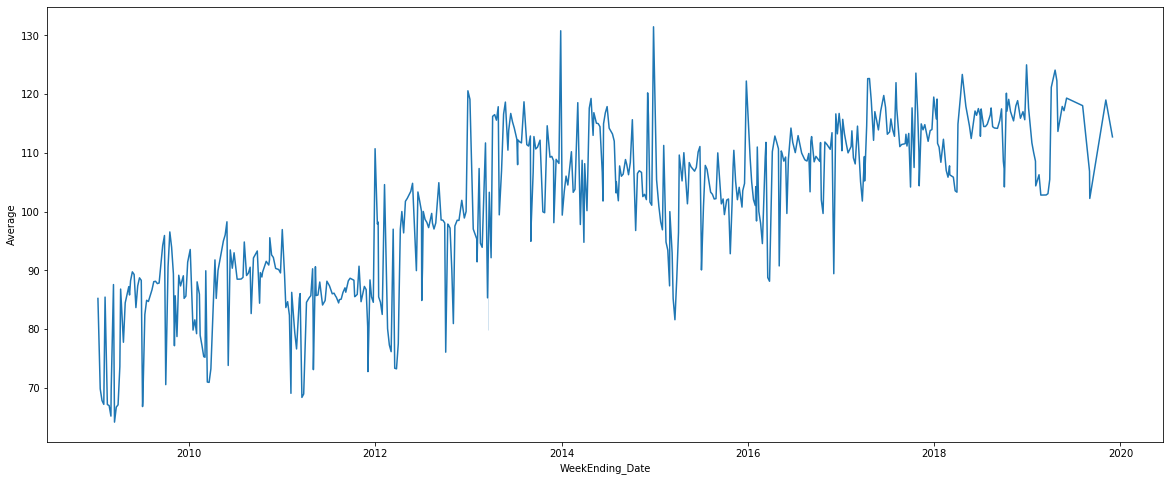

In [20]:
plt.figure(figsize = (20,8))
sns.lineplot(x = 'WeekEnding_Date', y = 'Average',data = train_data)

In [21]:
train_data_tobe_imputed = train_data.drop(columns=['WeekEnding_Date'])
test_data_tobe_imputed = test_data.drop(columns=['WeekEnding_Date'])

In [22]:
klib.corr_mat(train_data_tobe_imputed)

,Kolkata_Average_Price,Kolkata_Ref_Price,Bangalore_Average_Price,Bangalore_Ref_Price,Cochin_Average_Price,Cochin_Ref_Price,Darjeeling_Average_Price,Darjeeling_Ref_Price,Ernakulam_Average_Price,Ernakulam_Ref_Price,Siliguri_Average_Price,Siliguri_Ref_Price,Guwahati_Average_Price,Guwahati_Ref_Price,Average
Kolkata_Average_Price,1.00,0.80,0.89,0.76,0.76,0.66,0.34,0.33,0.14,0.09,0.27,0.20,0.07,0.09,0.73
Kolkata_Ref_Price,0.80,1.00,0.74,0.92,0.63,0.82,0.41,0.49,0.11,0.28,0.26,0.40,0.05,0.18,0.80
Bangalore_Average_Price,0.89,0.74,1.00,0.78,0.86,0.72,0.40,0.36,0.20,0.12,0.33,0.25,0.12,0.09,0.76
Bangalore_Ref_Price,0.76,0.92,0.78,1.00,0.69,0.88,0.43,0.52,0.13,0.32,0.29,0.43,0.05,0.20,0.81
Cochin_Average_Price,0.76,0.63,0.86,0.69,1.00,0.75,0.51,0.40,0.36,0.19,0.48,0.31,0.27,0.14,0.79
Cochin_Ref_Price,0.66,0.82,0.72,0.88,0.75,1.00,0.44,0.59,0.17,0.44,0.34,0.54,0.09,0.32,0.83
Darjeeling_Average_Price,0.34,0.41,0.40,0.43,0.51,0.44,1.00,0.64,0.82,0.53,0.90,0.60,0.69,0.33,0.74
Darjeeling_Ref_Price,0.33,0.49,0.36,0.52,0.40,0.59,0.64,1.00,0.32,0.82,0.49,0.91,0.12,0.67,0.73
Ernakulam_Average_Price,0.14,0.11,0.20,0.13,0.36,0.17,0.82,0.32,1.00,0.27,0.89,0.29,0.89,0.07,0.48
Ernakulam_Ref_Price,0.09,0.28,0.12,0.32,0.19,0.44,0.53,0.82,0.27,1.00,0.41,0.96,0.15,0.88,0.58


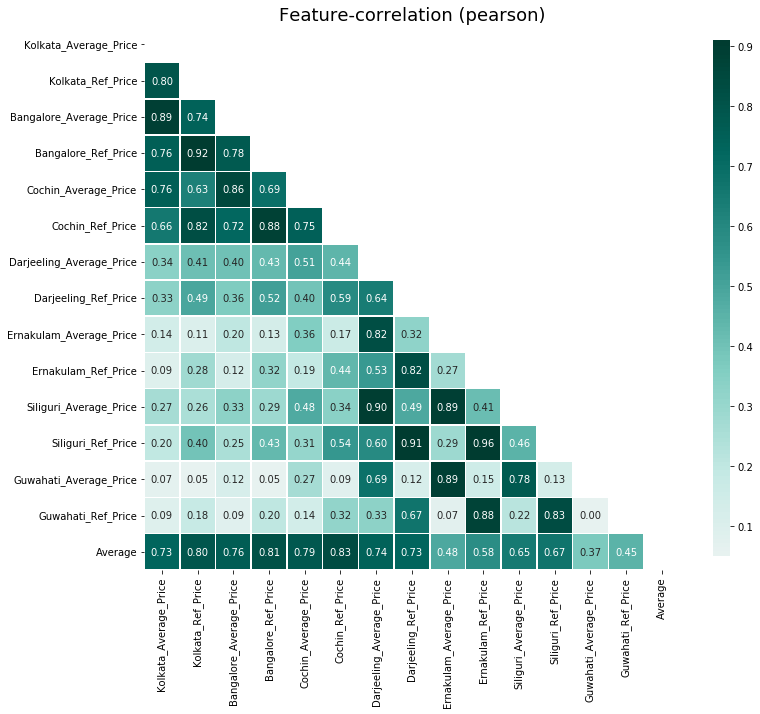

In [23]:
klib.corr_plot(train_data_tobe_imputed)

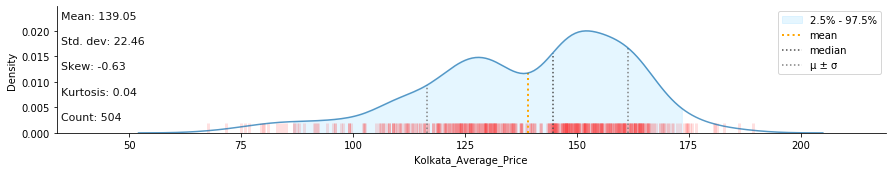

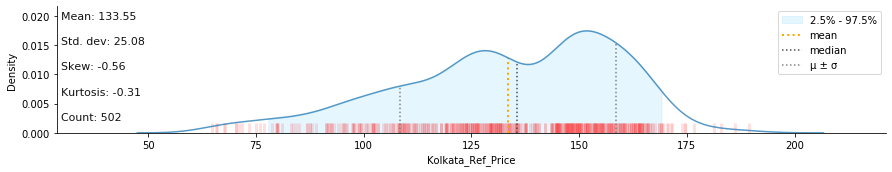

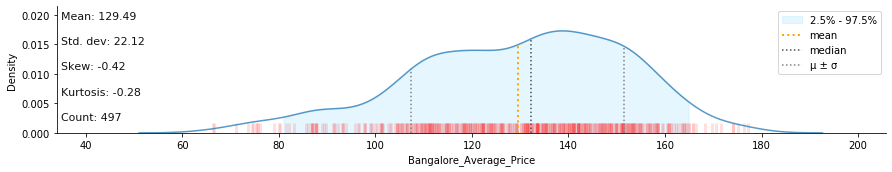

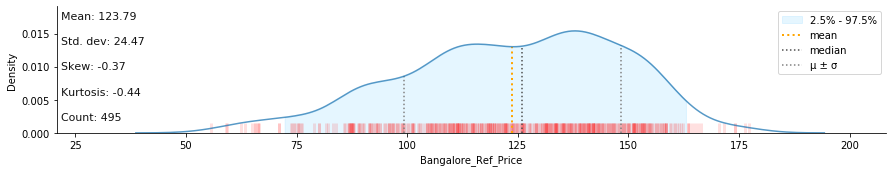

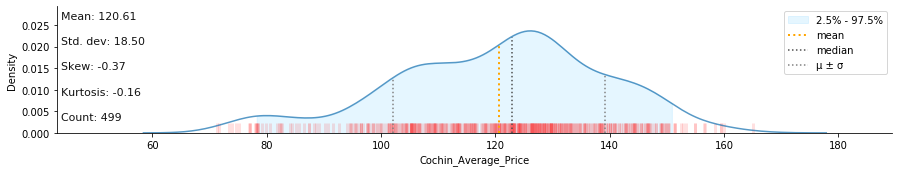

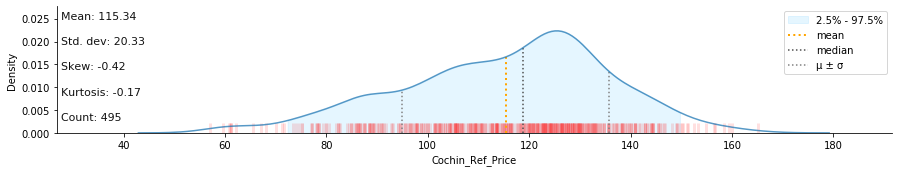

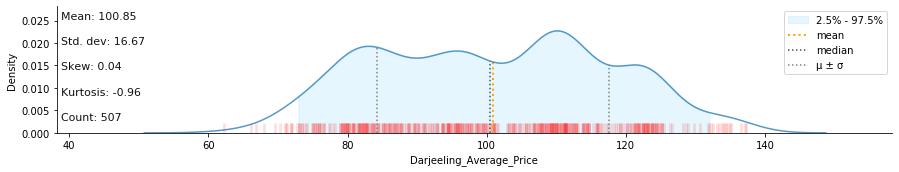

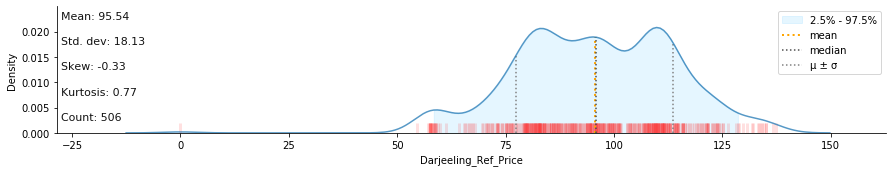

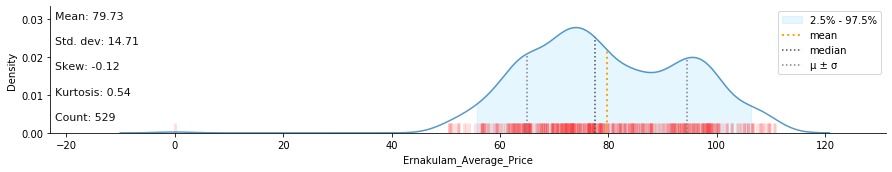

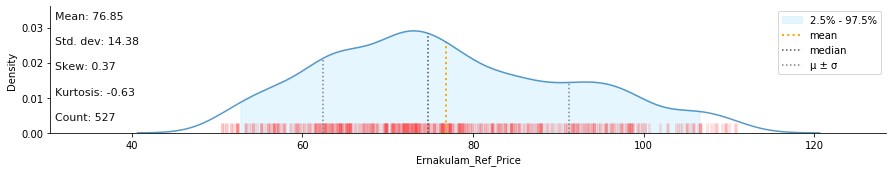

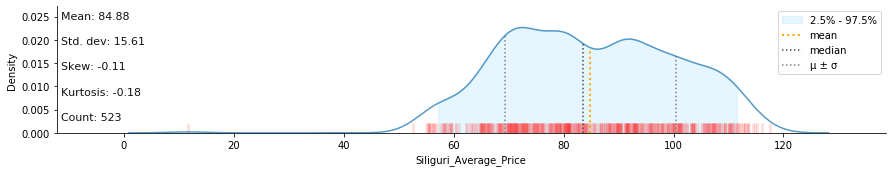

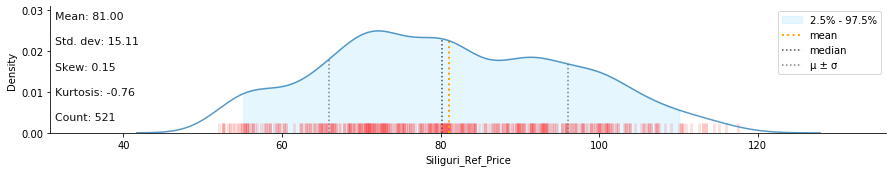

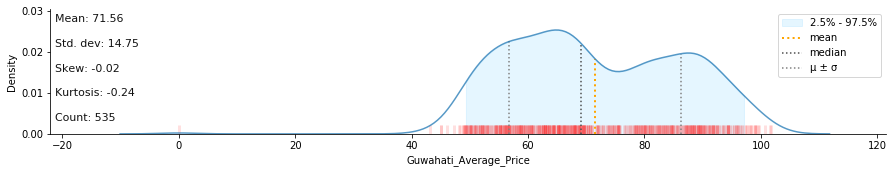

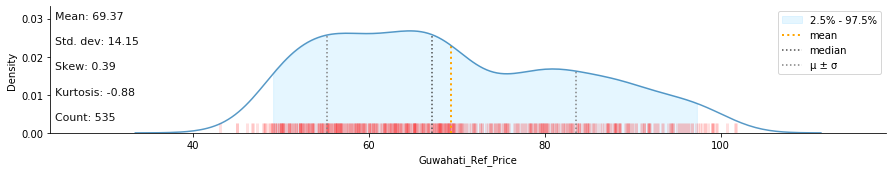

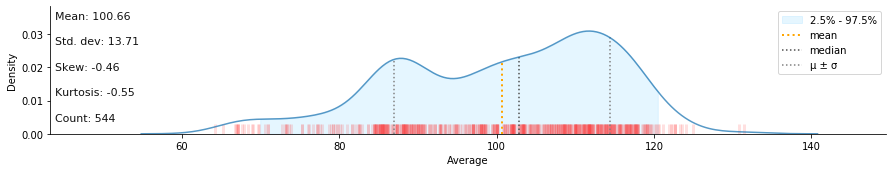

In [24]:
klib.dist_plot(train_data_tobe_imputed)

In [25]:
train_data_imputed = data_imputer(train_data_tobe_imputed)
test_data_imputed = data_imputer(test_data_tobe_imputed)

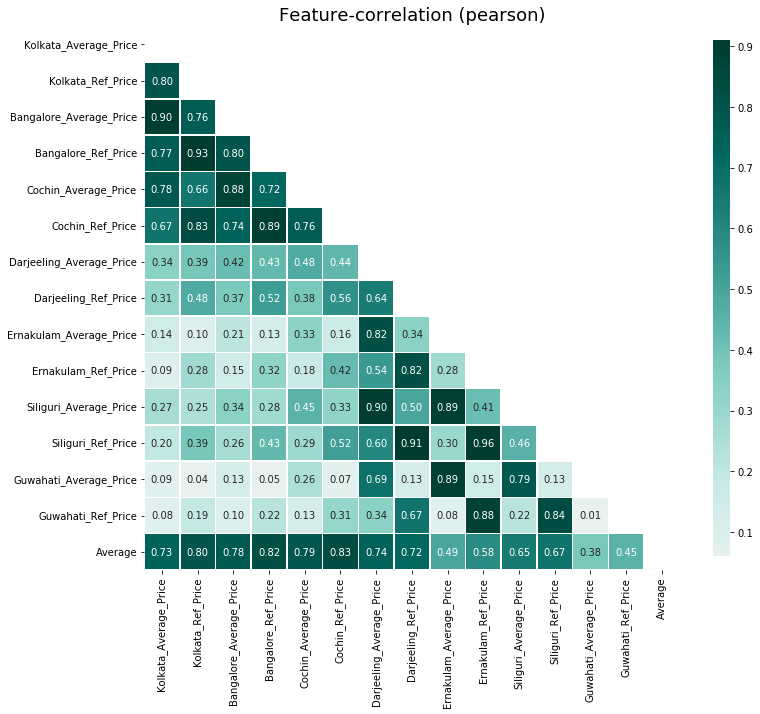

In [26]:
klib.corr_plot(train_data_imputed)

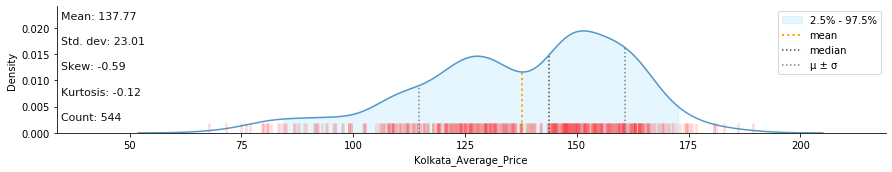

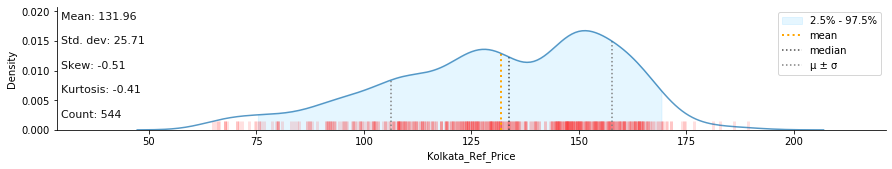

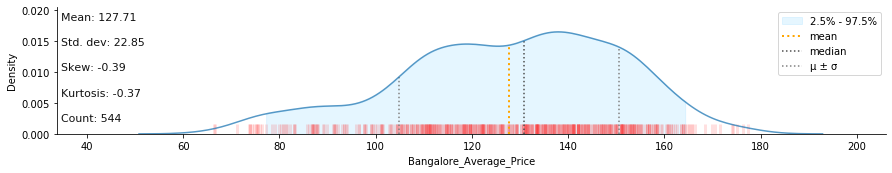

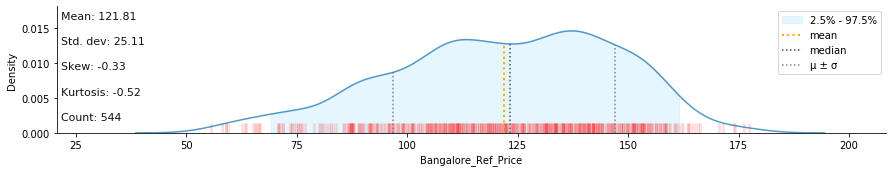

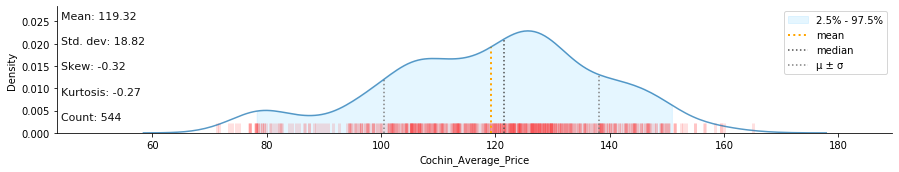

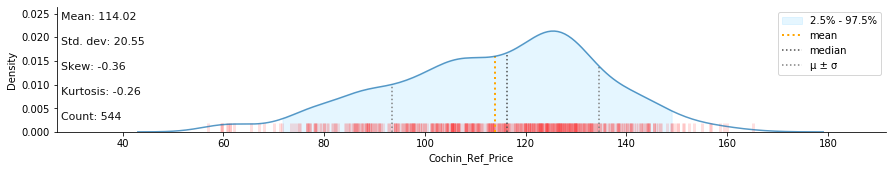

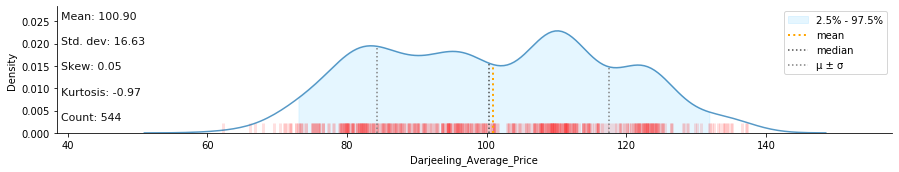

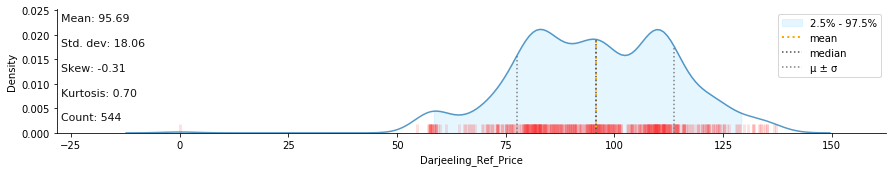

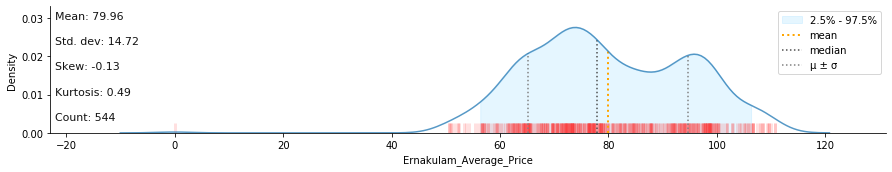

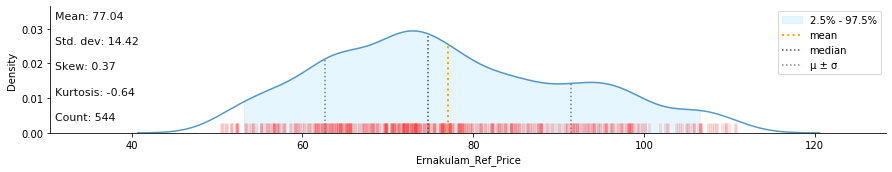

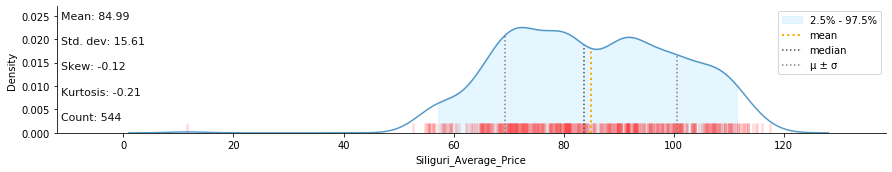

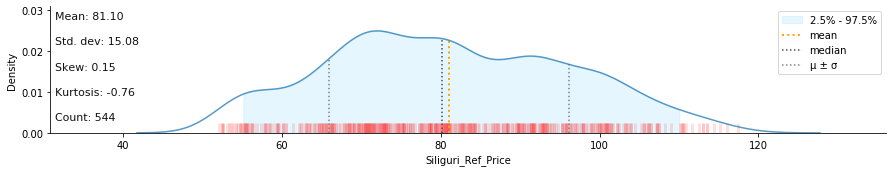

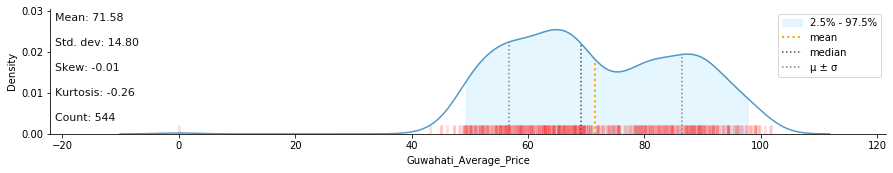

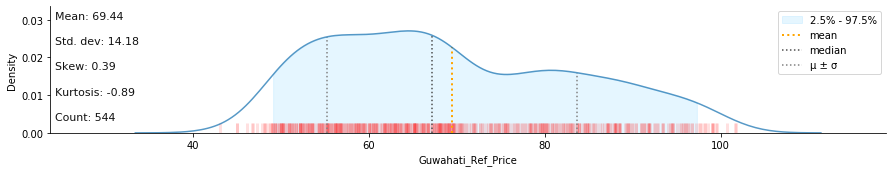

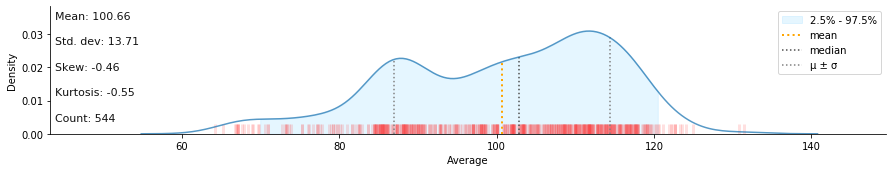

In [27]:
klib.dist_plot(train_data_imputed)

In [28]:
train_data_imputed = train_data_imputed.round(3)
test_data_imputed = test_data_imputed.round(3)

In [29]:
check_missing_values(train_data_imputed)

Percentage of Missing values in categorical colmuns
 Empty DataFrame
Columns: [column_name, dtype, percent_missing]
Index: []

Percentage of Missing values in non categorical colmuns
 Empty DataFrame
Columns: [column_name, dtype, percent_missing]
Index: []



In [30]:
check_missing_values(test_data_imputed)

Percentage of Missing values in categorical colmuns
 Empty DataFrame
Columns: [column_name, dtype, percent_missing]
Index: []

Percentage of Missing values in non categorical colmuns
 Empty DataFrame
Columns: [column_name, dtype, percent_missing]
Index: []



In [31]:
train_data_imputed.head()

,Kolkata_Average_Price,Kolkata_Ref_Price,Bangalore_Average_Price,Bangalore_Ref_Price,Cochin_Average_Price,Cochin_Ref_Price,Darjeeling_Average_Price,Darjeeling_Ref_Price,Ernakulam_Average_Price,Ernakulam_Ref_Price,Siliguri_Average_Price,Siliguri_Ref_Price,Guwahati_Average_Price,Guwahati_Ref_Price,Average
0,99.01,79.79,86.943,76.19,84.020,70.07,81.66,57.83,68.94,51.67,70.74,53.88,65.55,46.75,69.700
1,97.74,78.73,87.480,73.97,82.720,68.17,83.31,58.02,67.24,52.23,70.47,53.39,67.39,46.84,70.550
2,95.95,71.01,87.660,71.01,80.580,67.16,82.25,57.49,69.64,52.48,71.66,53.18,69.51,48.04,69.830
3,94.14,73.38,85.690,65.66,80.857,65.57,80.87,54.59,68.93,53.43,71.12,52.07,69.14,48.50,67.847
4,91.45,70.39,82.970,64.99,79.270,62.09,80.76,57.06,69.65,53.38,72.30,52.50,69.39,50.33,67.197


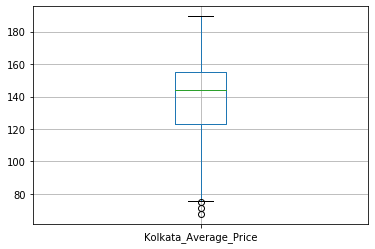

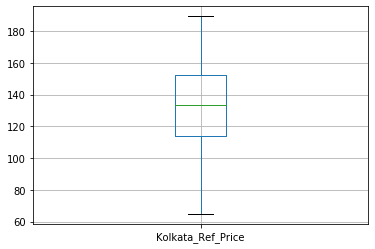

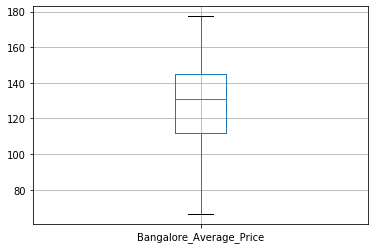

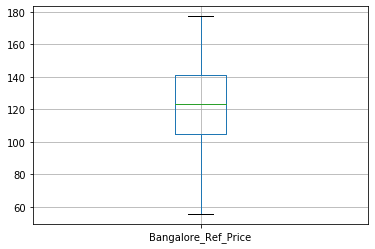

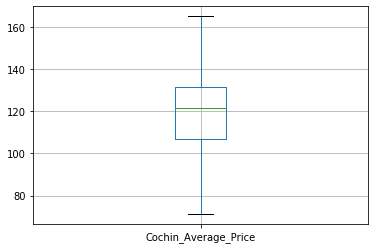

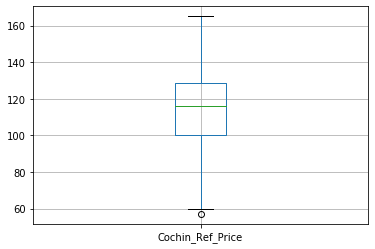

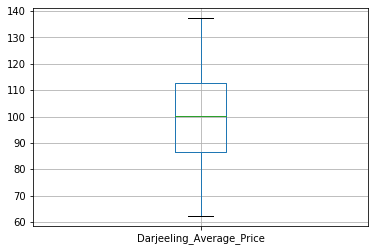

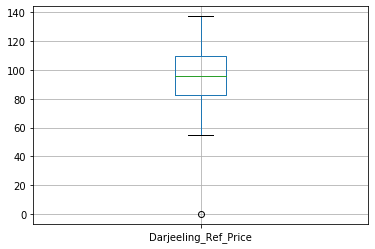

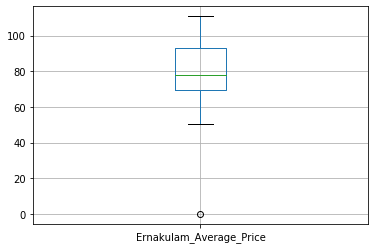

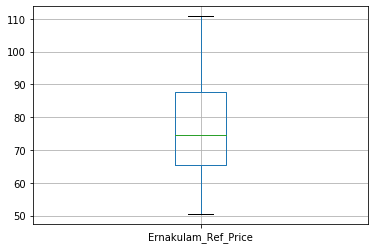

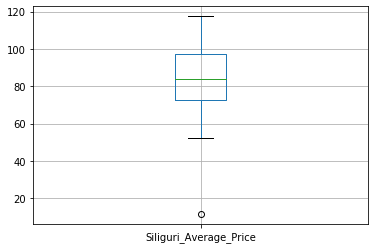

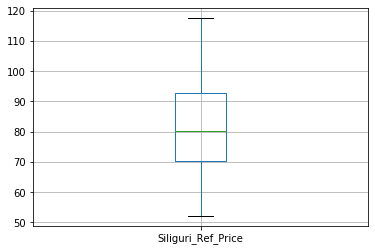

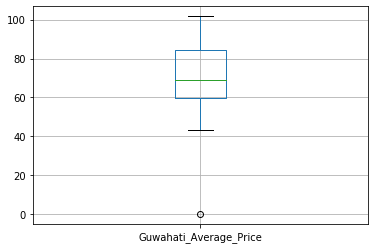

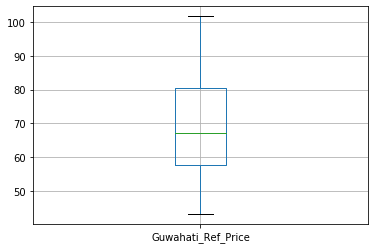

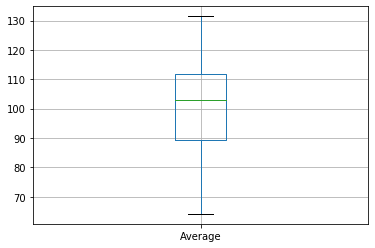

In [32]:
box_plots(train_data_imputed)

In [33]:
train_data_imputed_no_outlier_IQR = remove_all_outliers_EQR_rec(train_data_imputed)


Outliers in each col:
 Kolkata_Average_Price       3
Kolkata_Ref_Price           0
Bangalore_Average_Price     0
Bangalore_Ref_Price         0
Cochin_Average_Price        0
Cochin_Ref_Price            1
Darjeeling_Average_Price    0
Darjeeling_Ref_Price        1
Ernakulam_Average_Price     1
Ernakulam_Ref_Price         0
Siliguri_Average_Price      1
Siliguri_Ref_Price          0
Guwahati_Average_Price      1
Guwahati_Ref_Price          0
Average                     0
dtype: int64
Total Outliers:  8
Shape of dataset after removing outliers : (537, 15)

Outliers in each col:
 Kolkata_Average_Price       1
Kolkata_Ref_Price           0
Bangalore_Average_Price     0
Bangalore_Ref_Price         0
Cochin_Average_Price        0
Cochin_Ref_Price            3
Darjeeling_Average_Price    0
Darjeeling_Ref_Price        0
Ernakulam_Average_Price     0
Ernakulam_Ref_Price         0
Siliguri_Average_Price      0
Siliguri_Ref_Price          0
Guwahati_Average_Price      0
Guwahati_Ref_Price         

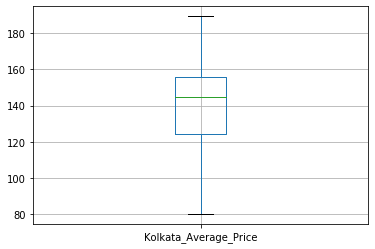

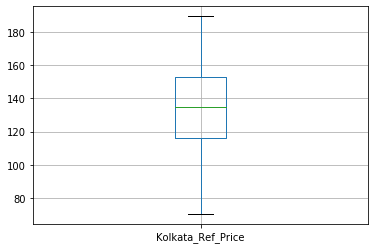

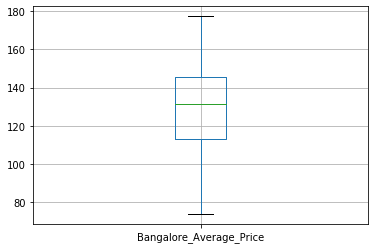

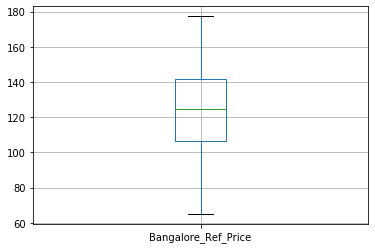

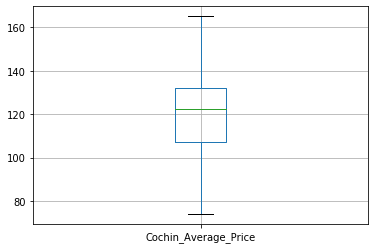

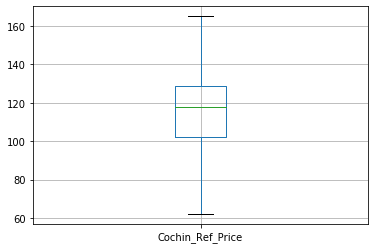

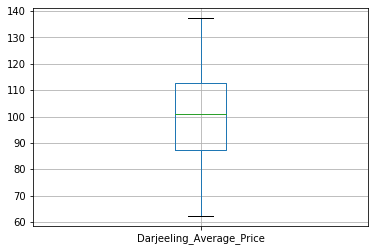

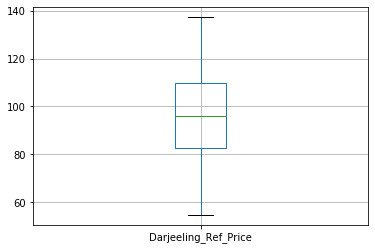

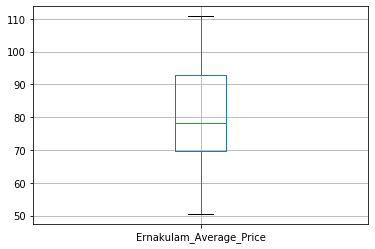

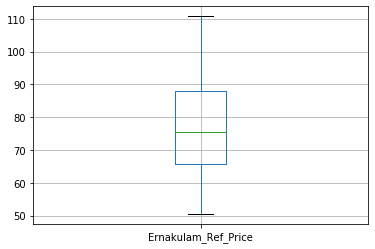

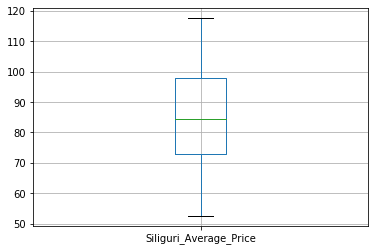

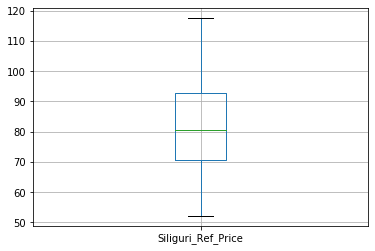

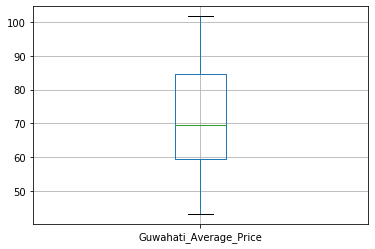

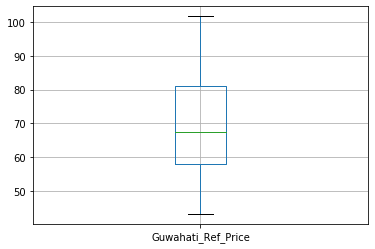

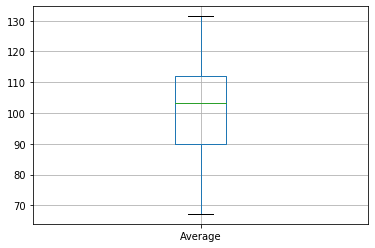

In [34]:
box_plots(train_data_imputed_no_outlier_IQR)

In [35]:
train_data_imputed_no_outlier_IQR = train_data_imputed_no_outlier_IQR.drop(columns=['Average'])
train_data_imputed_no_outlier_IQR['Average'] = train_data_imputed_no_outlier_IQR.mean(axis=1)
train_data_imputed_no_outlier_IQR = train_data_imputed_no_outlier_IQR.round(3)

In [36]:
train_data_imputed_no_outlier_IQR.head()

,Kolkata_Average_Price,Kolkata_Ref_Price,Bangalore_Average_Price,Bangalore_Ref_Price,Cochin_Average_Price,Cochin_Ref_Price,Darjeeling_Average_Price,Darjeeling_Ref_Price,Ernakulam_Average_Price,Ernakulam_Ref_Price,Siliguri_Average_Price,Siliguri_Ref_Price,Guwahati_Average_Price,Guwahati_Ref_Price,Average
0,99.01,79.79,86.943,76.19,84.020,70.07,81.66,57.83,68.94,51.67,70.74,53.88,65.55,46.75,70.932
1,97.74,78.73,87.480,73.97,82.720,68.17,83.31,58.02,67.24,52.23,70.47,53.39,67.39,46.84,70.550
2,95.95,71.01,87.660,71.01,80.580,67.16,82.25,57.49,69.64,52.48,71.66,53.18,69.51,48.04,69.830
3,94.14,73.38,85.690,65.66,80.857,65.57,80.87,54.59,68.93,53.43,71.12,52.07,69.14,48.50,68.853
4,91.45,70.39,82.970,64.99,79.270,62.09,80.76,57.06,69.65,53.38,72.30,52.50,69.39,50.33,68.324


In [37]:
#Applying AutoML

#!pip install h2o
import h2o
from h2o.automl import H2OAutoML

h2o.init(
    nthreads=-1,     # number of threads when launching a new H2O server
    max_mem_size=12  # in gigabytes
)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.301-b09, mixed mode)
  Starting server from C:\Users\sbhardwaj\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\SBHARD~1\AppData\Local\Temp\5\tmp2etx08mo
  JVM stdout: C:\Users\SBHARD~1\AppData\Local\Temp\5\tmp2etx08mo\h2o_sbhardwaj_started_from_python.out
  JVM stderr: C:\Users\SBHARD~1\AppData\Local\Temp\5\tmp2etx08mo\h2o_sbhardwaj_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.5
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_sbhardwaj_svofu7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,10.67 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


In [38]:
train = h2o.H2OFrame(train_data_imputed_no_outlier_IQR)
x = train.columns
y = "Average"
x.remove(y)
aml = H2OAutoML(max_models=5, seed=1)
aml.train(x=x, y=y, training_frame=train)

Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
18:57:55.822: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


In [39]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GLM_1_AutoML_20210823_185755,2.86882e-05,0.00535613,2.86882e-05,0.00429684,5.61153e-05
StackedEnsemble_AllModels_AutoML_20210823_185755,0.000709554,0.0266375,0.000709554,0.0221626,0.000288676
StackedEnsemble_BestOfFamily_AutoML_20210823_185755,0.000723566,0.0268992,0.000723566,0.0223522,0.000291905
GBM_1_AutoML_20210823_185755,1.15639,1.07536,1.15639,0.759213,0.0104896
GBM_2_AutoML_20210823_185755,1.16864,1.08103,1.16864,0.797781,0.0107776
GBM_3_AutoML_20210823_185755,1.31507,1.14677,1.31507,0.793532,0.0115535
DRF_1_AutoML_20210823_185755,1.40645,1.18594,1.40645,0.871644,0.0117884


In [40]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

metalearner.coef_norm()

C:\Users\sbhardwaj\Anaconda3\lib\site-packages\h2o\estimators\stackedensemble.py:836: H2ODeprecationWarning: The usage of stacked_ensemble.metalearner()['name'] will be deprecated. Metalearner now returns the metalearner object. If you need to get the 'name' please use stacked_ensemble.metalearner().model_id
  H2ODeprecationWarning


{'Intercept': 101.74528166351607,
 'GLM_1_AutoML_20210823_185755': 12.35210307071305,
 'GBM_1_AutoML_20210823_185755': 0.035091497388287075,
 'GBM_2_AutoML_20210823_185755': 0.0008957647848664855,
 'GBM_3_AutoML_20210823_185755': 0.0,
 'DRF_1_AutoML_20210823_185755': 0.0}

In [41]:
test = h2o.H2OFrame(test_data_imputed)
preds = aml.leader.predict(test)

df = test.cbind(preds)
df.head(2)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


Kolkata_Average_Price,Kolkata_Ref_Price,Bangalore_Average_Price,Bangalore_Ref_Price,Cochin_Average_Price,Cochin_Ref_Price,Darjeeling_Average_Price,Darjeeling_Ref_Price,Ernakulam_Average_Price,Ernakulam_Ref_Price,Siliguri_Average_Price,Siliguri_Ref_Price,Guwahati_Average_Price,Guwahati_Ref_Price,predict
178.137,165.87,154.08,160.82,135.7,147.313,116.45,112.82,91.82,88.917,102.3,106.707,83.07,65.34,122.099
171.35,173.12,156.412,152.213,134.81,141.407,110.68,115.33,90.68,76.34,94.437,106.707,81.34,76.48,120.094


In [42]:
res = df[:, ["predict"]]
print(res.head(2))
res = res.set_names(['Average'])

predict
122.099
120.094


In [43]:
h2o.export_file(res, path = 'MachineHack_TeaPricePred_submissionFile.csv', force = True)

Export File progress: |███████████████████████████████████████████████████| 100%
